
Fused Softmax
=================
In this tutorial, you will write a fused softmax operation that is significantly faster than PyTorch's native op for a particular class of matrices: those whose rows can fit in the GPU's SRAM.
You will learn about:

- The benefits of kernel fusion for bandwidth-bound operations.
- Reduction operators in Triton.


# Motivations
 - Custom GPU kernels for elementwise additions are educationally valuable but won't get you very far in practice.
 - Let us consider instead the case of a simple (numerically stabilized) softmax operation:


In [5]:
import torch
import triton
import triton.language as tl

In [6]:
# Compute the row-wise softmax of x
@torch.jit.script
def naive_softmax(x):
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read 2MN elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read 2MN elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 7MN elements ; wrote 3MN + 2M elements
    return ret



In [7]:
# %%
# When implemented naively in pytorch, computing :code:`y = naive_softmax(x)` for :math:`x \in R^{M \times N}` requires reading :math:`7MN` elements from DRAM and writing back :math:`3MN + 2M` elements.
# This is obviously wasteful; we'd prefer to have a custom "fused" kernel that only reads X once and does all the necessary computations on-chip.
# Doing so would require reading and writing back only :math:`MN` bytes, so we could expect a theoretical speed-up of ~5x (i.e., :math:`(10MN + 2M) / 2MN`).
# The `torch.jit.script` flags aims to perform this kind of "kernel fusion" automatically but, as we will see later, it is still far from ideal.

# %%
# Compute Kernel
# ----------------
# Our softmax kernel works as follows: each program loads a row of the input matrix X, normalizes it and writes back the result to the output Y.
# Note that one important limitation of Triton is that each block must have a power-of-two number of elements,
# so we need to internally "pad" each row and guard the memory operations properly if we want to handle any possible input shapes:

In [8]:
#Softmax(dim=0)
@triton.jit
def _softmax(Y,  #output pointer 
             X,  #input pointer
             stride_xm, #stride tells us which to normalize
             stride_ym, #
             M, #num of rows
             N, #num of cols
             **meta):

    ## Note : Here stride is basically the amount you have to 
    ## move in memory to get to the next element
    ## Ex: so if x is 2D, lets say x = torch.randn(10, 20), 
    ##  then x[1, 1].data_ptr() = x[1, 0].data_ptr() + x.stride(1)

    # 1 program id per row index
    m = tl.program_id(0)
    
    # col indices
    # here BLOCK is the smallest power of two greater than `N`
    # In triton, the block size always has to be the power of 2
    # in general powers of 2 nicely fit / align with cache lines

    n = tl.arange(0, meta['BLOCK'])

    # the memory address of all the elements
    # that we want to load can be computed as follows
    #   m * stride_xm + n is how forward we want to move for the next pointer

    X = X + m * stride_xm + n  

    # x is the vector of values loaded. 
    # - float(inf) is so we dont go over the edge
    # if we do , penalize it and make it come back 
    x = tl.load(X, mask=n < N, other=-float('inf'))

    # Substract maximum for numerical stability
    z = x - tl.max(x, axis=0)
    # Note that exponentials in Triton are fast
    # but approximate (i.e., think __expf in CUDA)
    num = tl.exp(z)
    denom = tl.sum(num, axis=0)
    y = num / denom
    # Write back to Y
    Y = Y + m * stride_ym + n
    tl.store(Y, y, mask=n < N)

In [9]:
# %%
# We can create a helper function that enqueues the kernel and its (meta-)arguments for any given input tensor.


def next_power_of_2(n):
    n -= 1
    n |= n >> 1
    n |= n >> 2
    n |= n >> 4
    n |= n >> 8
    n |= n >> 16
    n += 1
    return n


In [10]:
def softmax(x):
    M, N = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK = next_power_of_2(N)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK >= 2048: num_warps = 8
    if BLOCK >= 4096: num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The launch grid is simple: we have one kernel instance per row of the input matrix
    _softmax[(M, )](y, x, 
                    x.stride(0), y.stride(0), 
                    M, N, 
                    num_warps=num_warps, BLOCK=BLOCK)
    return y



In [11]:
# %%
# Unit Test
# ----------

# %%
# We make sure that we test our kernel on a matrix with an irregular number of rows and columns.
# This will allow us to verify that our padding mechanism works.


In [12]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_tri = softmax(x)
y_ref = torch.softmax(x, axis=1)
print(torch.allclose(y_tri, y_ref))

#%%
# As expected, the results are identical.


True


In [13]:
# %%
# Benchmark
# -------------
# Here we will benchmark our operation as a function of the number of columns in the input matrix -- assuming 4096 rows.
# We will then compare its performance against (1) :code:`torch.softmax` and (2) the :code:`naive_softmax` defined above.


In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch-native', 'torch-jit'],  # possible values for `line_arg``
        line_names=["Triton", "Torch (native)", "Torch (jit)"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096}  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


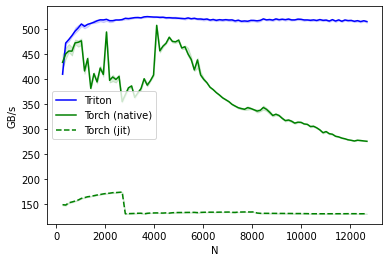

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  410.241017      434.013244   148.945453
1     384.0  472.615390      450.935778   148.159762
2     512.0  479.677926      456.696860   152.809091
3     640.0  487.619051      456.378833   154.274945
4     768.0  496.484863      472.899587   156.193051
..      ...         ...             ...          ...
93  12160.0  516.117037      276.412725   130.859866
94  12288.0  517.432019      278.007825   130.810376
95  12416.0  515.592028      277.367783   130.673245
96  12544.0  517.278369      276.558933   130.751788
97  12672.0  515.662361      275.929321   130.718141

[98 rows x 4 columns]


In [15]:
benchmark.run(show_plots=True, print_data=True)

In [ ]:
# %%
# In the above plot, we can see that:
#
#  - Triton is 2-3x faster than the Torch JIT.
#  - Triton is even faster than :code:`torch.softmax`. My guess from looking at the source-code of the `PyTorch kernel <https://github.com/pytorch/pytorch/blob/9409a3a39b7149bb2d833a89e0c944109bef7c27/caffe2/operators/softmax_ops.cu#L240>`_ is that PyTorch only partially fuses the computation of the softmax.
#    This means that -- when temporary data is too large to fit entirely in the GPU's cache -- it transfers almost twice the amount of memory necessary.
#    Note that our Triton kernel is not only faster than PyTorch's CUDA kernel, it is also **easier to read, understand and maintain**.